# Plots the DFT interaction energy of the combined hBN-water system as a function of sheet-to-oxygen distance h.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def make_df_dft(data_path, ryd_per_ev=0.0734986176, mev_per_ev=1000):
    df = pd.read_table(
        data_path,
        delim_whitespace=True,
        header=None,
        names=[
            "system",
            "functional",
            "ecp",
            "ecut_ev",
            "Nk",
            "Ns",
            "total_energy_ryd",
        ],
    )
    df["total_energy_ev"] = df["total_energy_ryd"].values / ryd_per_ev
    df["total_energy_mev"] = df["total_energy_ev"].values * mev_per_ev
    return df


def make_df_rpa_int_energies(data_path):
    df = pd.read_table(
        data_path,
        delim_whitespace=True,
        header=None,
        names=[
            "system",
            "method",
            "int_energy_mev",
        ],
    )
    systems = df["system"].values
    df["h"] = [float(system.split("_")[-1]) for system in systems]
    df["system_without_h"] = ["_".join(system.split("_")[:-2]) for system in systems]
    return df


def gather_ref_energies(df):
    hBN_ref_energy = df[df.system == "hBN"]["total_energy_mev"].values[0]
    water_Oup_Hdown_ref_energy = df[df.system == "water_Oup_Hdown"][
        "total_energy_mev"
    ].values[0]
    return hBN_ref_energy, water_Oup_Hdown_ref_energy


def df_dft_trunc(df):
    df = df.loc[(df.system != "hBN") & (df.system != "water_Oup_Hdown")]
    return df


def make_df_dft_int_energies(df_dft):
    df_dft_int_energies = pd.DataFrame({})
    hBN_ref_energy, water_Oup_Hdown_ref_energy = gather_ref_energies(df_dft)
    df_dft = df_dft_trunc(df_dft)
    df_dft_int_energies["system"] = df_dft["system"].values
    functionals = df_dft["functional"].values
    df_dft_int_energies["method"] = [f"dft-{functional}" for functional in functionals]
    df_dft_int_energies["int_energy_mev"] = (
        df_dft["total_energy_mev"].values - hBN_ref_energy - water_Oup_Hdown_ref_energy
    )
    systems = df_dft_int_energies["system"].values
    df_dft_int_energies["h"] = [float(system.split("_")[-1]) for system in systems]
    df_dft_int_energies["system_without_h"] = [
        "_".join(system.split("_")[:-2]) for system in systems
    ]
    return df_dft_int_energies


def add_color_code(
    row, color_code={"rpa": "k", "dft-pbe": "b", "dft-b3lyp": "r", "dft-pbe0": "g"}
):
    for method in color_code:
        if method in row:
            return color_code[method]


def plot_int_energy(df):
    system = df.system_without_h.values[0]
    plt.figure(figsize=(7, 5))
    plt.ylim(-130, 60)
    plt.title(f"Interaction energy curve for {system}")
    plt.xlabel("Sheet-to-oxygen distance h (A)")
    plt.ylabel(r"$\Delta E_{int}$ (meV)")
    for method in df.method.unique():
        data = df[(df.system_without_h == system) & (df.method == method)].copy()
        if not data.empty:
            plt.plot(
                "h",
                "int_energy_mev",
                "-o",
                data=data,
                color=data["color"].values[0],
                label=method,
            )
    plt.axhline(y=0, linestyle="--", color="k")
    plt.legend()
    save_path = f"/Users/Nathan/Desktop/{system}_int_energy_plot.png"
    print(f"Saving png file to {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")

In [4]:
dft_data_path = "dft_total_energy_data.txt"
df_dft = make_df_dft(dft_data_path)
df_dft = df_dft[df_dft.ecp == "hgh"]
df_dft

,system,functional,ecp,ecut_ev,Nk,Ns,total_energy_ryd,total_energy_ev,total_energy_mev
10,hBN_water_Oup_Hdown_h_2.9907,pbe0,hgh,700,3,3,-950.269185,-12929.075626,-1.292908e+07
11,hBN_water_Oup_Hdown_h_3.1944,pbe0,hgh,700,3,3,-950.273096,-12929.128834,-1.292913e+07
12,hBN_water_Oup_Hdown_h_3.3889,pbe0,hgh,700,3,3,-950.273886,-12929.139575,-1.292914e+07
13,hBN_water_Oup_Hdown_h_3.5926,pbe0,hgh,700,3,3,-950.274394,-12929.146494,-1.292915e+07
14,hBN_water_Oup_Hdown_h_3.7963,pbe0,hgh,700,3,3,-950.274312,-12929.145373,-1.292915e+07
15,hBN_water_Oup_Hdown_h_4.5000,pbe0,hgh,700,3,3,-950.273520,-12929.134599,-1.292913e+07
16,hBN_water_Oup_Hdown_h_5.0093,pbe0,hgh,700,3,3,-950.273056,-12929.128289,-1.292913e+07
17,hBN_water_Oup_Hdown_h_6.0093,pbe0,hgh,700,3,3,-950.272748,-12929.124098,-1.292912e+07
18,hBN,pbe0,hgh,700,3,3,-916.743995,-12472.942015,-1.247294e+07
19,water_Oup_Hdown,pbe0,hgh,700,3,1,-33.528889,-456.183937,-4.561839e+05


In [9]:
rpa_data_path = "rpa_interaction_energy_data.txt"
df_dft_int_energies = make_df_dft_int_energies(df_dft)
df_int_energies = pd.concat(
    [df_dft_int_energies, make_df_rpa_int_energies(rpa_data_path)]
)
df_int_energies["color"] = df_int_energies["method"].apply(add_color_code)
df_int_energies = df_int_energies[df_int_energies.system_without_h == "hBN_water_Oup_Hdown"]
df_int_energies

,system,method,int_energy_mev,h,system_without_h,color
0,hBN_water_Oup_Hdown_h_2.9907,dft-pbe0,50.326389,2.9907,hBN_water_Oup_Hdown,b
1,hBN_water_Oup_Hdown_h_3.1944,dft-pbe0,-2.881823,3.1944,hBN_water_Oup_Hdown,b
2,hBN_water_Oup_Hdown_h_3.3889,dft-pbe0,-13.622569,3.3889,hBN_water_Oup_Hdown,b
3,hBN_water_Oup_Hdown_h_3.5926,dft-pbe0,-20.541883,3.5926,hBN_water_Oup_Hdown,b
4,hBN_water_Oup_Hdown_h_3.7963,dft-pbe0,-19.420365,3.7963,hBN_water_Oup_Hdown,b
5,hBN_water_Oup_Hdown_h_4.5000,dft-pbe0,-8.646965,4.5000,hBN_water_Oup_Hdown,b
6,hBN_water_Oup_Hdown_h_5.0093,dft-pbe0,-2.336370,5.0093,hBN_water_Oup_Hdown,b
7,hBN_water_Oup_Hdown_h_6.0093,dft-pbe0,1.854593,6.0093,hBN_water_Oup_Hdown,b
0,hBN_water_Oup_Hdown_h_2.9907,rpa,-29.313725,2.9907,hBN_water_Oup_Hdown,k
1,hBN_water_Oup_Hdown_h_3.1944,rpa,-62.175018,3.1944,hBN_water_Oup_Hdown,k


In [10]:
data_path = "all_interaction_energy_data.txt"
df_int_energies.to_csv(data_path, header=None, index=None, sep=" ", mode="w")

Saving png file to /Users/Nathan/Desktop/hBN_water_Oup_Hdown_int_energy_plot.png


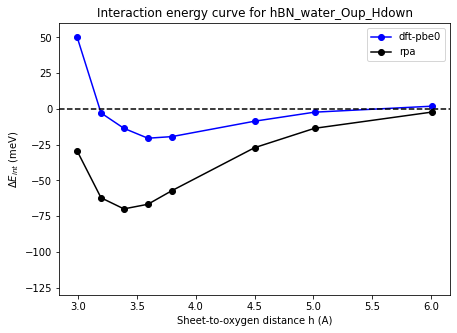

In [12]:
plot_int_energy(df_int_energies)